<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/pretrained_model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import random 

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm==0.4.5 pytorch-lightning optuna

     |████████████████████████████████| 287 kB 6.8 MB/s 
     |████████████████████████████████| 582 kB 48.3 MB/s 
     |████████████████████████████████| 308 kB 55.0 MB/s 
     |████████████████████████████████| 408 kB 49.3 MB/s 
     |████████████████████████████████| 136 kB 52.0 MB/s 
     |████████████████████████████████| 596 kB 42.0 MB/s 
     |████████████████████████████████| 1.1 MB 51.2 MB/s 
     |████████████████████████████████| 81 kB 7.0 MB/s 
     |████████████████████████████████| 210 kB 80.7 MB/s 
     |████████████████████████████████| 271 kB 69.7 MB/s 
     |████████████████████████████████| 144 kB 73.2 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 146 kB 70.6 MB/s 
     |████████████████████████████████| 113 kB 77.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=111

In [466]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import optuna
from drive.MyDrive.MIT.HODL.ssast.src.models.ast_models import ASTModel
import matplotlib.pyplot as plt 
import librosa

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchaudio import transforms

In [ ]:
#!wget -O mel_spec_datadict https://www.dropbox.com/s/nrebpbe5g97sptu/mel_spec_datadict?dl=0
!wget -O mel_spec_datadict_all https://www.dropbox.com/s/e9l6xid06080g6z/mel_spec_datadict_all?dl=0

--2022-05-03 19:01:00--  https://www.dropbox.com/s/e9l6xid06080g6z/mel_spec_datadict_all?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/e9l6xid06080g6z/mel_spec_datadict_all [following]
--2022-05-03 19:01:01--  https://www.dropbox.com/s/raw/e9l6xid06080g6z/mel_spec_datadict_all
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc98b85cb1d4ff44bbdb56045309.dl.dropboxusercontent.com/cd/0/inline/BkmL_3S92VTIc_LeXdXFVTHMFN5BNi2s2HQAQh5OkfYLK6ZpVSf8SdbyOBnQFEGcUFUpGYFLEvGfWGYIBcmM-oyXOSPU-g4CfM9S9BsEfJo17GyrXjhWHsml6oTWVLzsEV3bAthrJxzbcXyh12EVNYDdehTrCizp7grLeTm8pjgSyg/file# [following]
--2022-05-03 19:01:01--  https://uc98b85cb1d4ff44bbdb56045309.dl.dropboxusercontent.com/cd/0/inline/BkmL_3S92VTIc_LeXdXFVTHMFN5BNi2s2HQA

In [ ]:
with open('mel_spec_datadict_all', 'rb') as f:
    mel_spec_datadict = pickle.load(f)
# with open('mel_spec_datadict_all', 'rb') as f:

In [ ]:
!wget -O raw_datadict_all https://www.dropbox.com/s/yfi64jhyk9wzv6l/raw_datadict_all?dl=0

--2022-05-03 19:03:56--  https://www.dropbox.com/s/yfi64jhyk9wzv6l/raw_datadict_all?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/yfi64jhyk9wzv6l/raw_datadict_all [following]
--2022-05-03 19:03:57--  https://www.dropbox.com/s/raw/yfi64jhyk9wzv6l/raw_datadict_all
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1ca114251c79be673614dd4fff.dl.dropboxusercontent.com/cd/0/inline/Bkl3SjPYcrFcFRzQhSj3srZU_L7jkrvbOMuf8vAVjzet2H3R818eE8yw34APtpO4MbTRuuagCx1YQ5eivHRkBwOmgmZtmjSoWIPvz2WQMjfvzfDoxfDfmpLX93h-994kSNqX3i6sEzRTs73-DQ-Qc4J0iDuhpnN_OhkJu-NJy2a6rA/file# [following]
--2022-05-03 19:03:57--  https://uc1ca114251c79be673614dd4fff.dl.dropboxusercontent.com/cd/0/inline/Bkl3SjPYcrFcFRzQhSj3srZU_L7jkrvbOMuf8vAVjzet2H3R81

In [ ]:
with open('raw_datadict_all', 'rb') as f:
  raw_datadict_all = pickle.load(f)

In [ ]:
X_train, y_train = mel_spec_datadict['X_train']
X_val, y_val = mel_spec_datadict['X_holdout']
X_test, y_test = mel_spec_datadict['X_test']

X_train = mel_spec_datadict['X_train'][0]
X_val = mel_spec_datadict['X_holdout'][0]
X_test = mel_spec_datadict['X_test'][0]

y_train = raw_datadict_all['X_train'][0]['popGreaterThan50']
y_val = raw_datadict_all['X_holdout'][0]['popGreaterThan50']
y_test = raw_datadict_all['X_test'][0]['popGreaterThan50']
y_train2 = raw_datadict_all['X_train'][0]['popularity']
y_val2 = raw_datadict_all['X_holdout'][0]['popularity']
y_test2 = raw_datadict_all['X_test'][0]['popularity']
y_train3 = (raw_datadict_all['X_train'][0]['popularity'] >= 39).astype(int)
y_val3 = (raw_datadict_all['X_holdout'][0]['popularity'] >= 39).astype(int)
y_test3 = (raw_datadict_all['X_test'][0]['popularity'] >= 39).astype(int)

#focusing on top5 artists 
top5_artists = raw_datadict_all['X_train'][0].groupby("artists", as_index = False).count().sort_values("duration_ms", ascending = False)['artists'][:5]
top5_artists = top5_artists.values

X_train_artists = X_train[raw_datadict_all['X_train'][0]['artists'].isin(top5_artists),:,:,:]
X_val_artists = X_val[raw_datadict_all['X_holdout'][0]['artists'].isin(top5_artists),:,:,:]
X_test_artists = X_test[raw_datadict_all['X_test'][0]['artists'].isin(top5_artists),:,:,:]

y_train_artists = raw_datadict_all['X_train'][1][raw_datadict_all['X_train'][0]['artists'].isin(top5_artists)]
y_val_artists = raw_datadict_all['X_holdout'][1][raw_datadict_all['X_holdout'][0]['artists'].isin(top5_artists)]
y_test_artists = raw_datadict_all['X_test'][1][raw_datadict_all['X_test'][0]['artists'].isin(top5_artists)]

In [ ]:
pl.seed_everything(0, workers=True)

Global seed set to 0


0

In [431]:
# hyperparameters
NB_EPOCHS = 20
PATIENCE = 10
DOWNSAMPLING_FACTOR = 10
INPUT_TDIM = int(X_train.shape[2] / DOWNSAMPLING_FACTOR)
INPUT_FDIM = X_train.shape[1]
TASK = 'classification'
MONITOR = 'val_loss' #'val_loss'
MONITOR_HYPERPARAM = 'val_acc'

BATCH_SIZE = 32
LEARNING_RATE = 3e-4
DROPOUT_PROB = 0.0
USE_CLS_POOLING = True
NB_LAYERS_TO_FREEZE = 12
GRAD_ACC = 1

In [432]:
# downsampling
indices_to_isolate = [k * DOWNSAMPLING_FACTOR for k in range(INPUT_TDIM)]
len(indices_to_isolate)

129

In [612]:
# data
X_train = X_train_artists
X_val = X_val_artists
X_test = X_test_artists

X_train_downsampled = X_train[:,:,indices_to_isolate,:]
X_train_normalized = (X_train_downsampled - X_train_downsampled.mean(0)) / X_train_downsampled.std(0)
X_val_downsampled = X_val[:,:,indices_to_isolate,:]
X_val_normalized = (X_val_downsampled - X_train_downsampled.mean(0)) / X_train_downsampled.std(0)
X_test_downsampled = X_test[:,:,indices_to_isolate,:]
X_test_normalized = (X_test_downsampled - X_train_downsampled.mean(0)) / X_train_downsampled.std(0)

X_train_ = torch.from_numpy(X_train_normalized).to(torch.float16).squeeze(-1)
X_val_ = torch.from_numpy(X_val_normalized).to(torch.float16).squeeze(-1)
X_test_ = torch.from_numpy(X_test_normalized).to(torch.float16).squeeze(-1)
# y_train_ = torch.from_numpy(y_train.values).to(torch.float16)
# y_val_ = torch.from_numpy(y_val.values).to(torch.float16)
# y_test_ = torch.from_numpy(y_test.values).to(torch.float16)
y_train_ = torch.tensor(pd.get_dummies(y_train_artists).to_numpy()).squeeze()
y_val_ = torch.tensor(pd.get_dummies(y_val_artists).to_numpy()).squeeze()
y_test_ = torch.tensor(pd.get_dummies(y_test_artists).to_numpy()).squeeze()

def transform_spec(spec):
  if np.random.random() <= 0.6:
    p = np.random.random()
    if p  <= 0.6:
      mask_param = 40
      transform = nn.Sequential(transforms.FrequencyMasking(freq_mask_param=mask_param), 
                                transforms.TimeMasking(time_mask_param=mask_param)).to(device)
      return transform(spec.to(device))
    elif 0.6 <= p <= 0.8:
      transform = transforms.Fade(fade_in_len = 50, fade_out_len = 50)
      return transform(spec.to(device))
    else:
      transform = transforms.PitchShift(sample_rate = 10, n_steps = 10, n_fft=128).to(device)
      return transform(spec.to(device))
  else:
    return spec

class SpectDataset(torch.utils.data.TensorDataset):
  # def __getitem__(self, index):
  #       return tuple(tensor[index] for tensor in self.tensors)
  def __getitem__(self, index):
    return tuple(transform_spec(tensor.to(device))[index] if len(tensor.shape) == 3 else tensor.to(device)[index]
                 for tensor in self.tensors)
    
train = SpectDataset(X_train_, y_train_)
val = torch.utils.data.TensorDataset(X_val_, y_val_)
test = torch.utils.data.TensorDataset(X_test_, y_test_)
# loaders
train_loader = torch.utils.data.DataLoader(train, sampler=torch.utils.data.RandomSampler(train), batch_size=BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val, sampler=torch.utils.data.SequentialSampler(val), batch_size=BATCH_SIZE*2)
test_loader = torch.utils.data.DataLoader(test, sampler=torch.utils.data.SequentialSampler(test), batch_size=BATCH_SIZE*2)

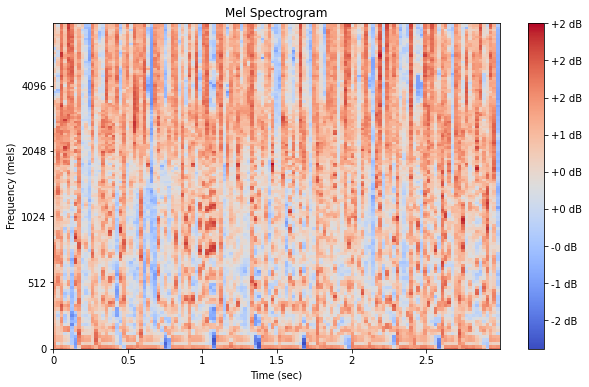

In [605]:
x = X_train_.to(device) 
#x = torch.tensor(mel_spec_datadict['X_holdout'][0][1]).to(device)
#transform = transforms.FrequencyMasking(freq_mask_param=40)
transform = transforms.PitchShift(sample_rate = 10, n_steps = 10, n_fft=128).to(device)

#nn.Sequential(transforms.FrequencyMasking(freq_mask_param=0.5), 
#                                transforms.TimeMasking(time_mask_param=0.5)).to(device)

fig, ax = plt.subplots(figsize=(10,6))
img = specshow(x[0,:,:].cpu().numpy(), x_axis='time', 
                               y_axis='mel', fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

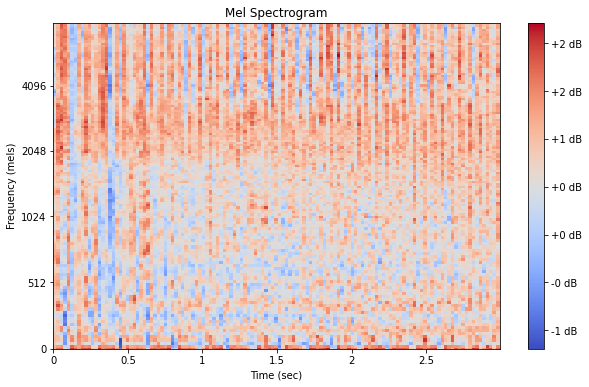

In [606]:
x = transform(x[0,:,:].cuda())
fig, ax = plt.subplots(figsize=(10,6))
img = specshow(x.cpu().numpy(), x_axis='time', 
                               y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram', xlabel='Time (sec)', ylabel='Frequency (mels)');

In [465]:
x.shape

(128, 1292, 1)

In [613]:
class CustomASTModel(pl.LightningModule):

  def __init__(
      self,
      input_fdim=INPUT_FDIM,
      input_tdim=INPUT_TDIM,
      use_small=True,
      use_cls_pooling=USE_CLS_POOLING,
      dropout_prob=DROPOUT_PROB,
      task='classification',
      regression_threshold=1.0,
      nb_layers_to_freeze=NB_LAYERS_TO_FREEZE,
      lr=LEARNING_RATE
  ):
    super().__init__()
    self.lr = lr
    self.dropout_prob = dropout_prob
    self.regression_threshold = regression_threshold

    if use_cls_pooling:
      self.pooling_type = 'ft_cls'
    else:
      self.pooling_type = 'ft_avgtok'

    assert(task in ['classification','regression', 'artists'])
    self.task = task

    if use_small:
      self.model = ASTModel(
          label_dim=1,    # no impact
          fshape=16, 
          tshape=16, 
          fstride=10, 
          tstride=10,
          input_fdim=input_fdim, 
          input_tdim=input_tdim, 
          model_size='small',
          pretrain_stage=False, 
          load_pretrained_mdl_path=(
              '/content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth'
          )
      )
    else:
       self.model = ASTModel(
          label_dim=1,
          fshape=16, 
          tshape=16, 
          fstride=10, 
          tstride=10,
          input_fdim=input_fdim, 
          input_tdim=input_tdim, 
          model_size='base',
          pretrain_stage=False, 
          load_pretrained_mdl_path=(
              '/content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Base-Patch-400.pth'
          )
       ) 
    self.cls_shape = self.model.v.blocks[-1].mlp.fc2.out_features
    mlp_head = nn.Sequential(
        nn.LayerNorm(self.cls_shape),
        nn.Linear(in_features=self.cls_shape, out_features=int(self.cls_shape / 2), bias=True),
        nn.Dropout(self.dropout_prob),
        nn.Linear(in_features=int(self.cls_shape / 2), out_features=5 if self.task == 'artists' else 1,
                  bias=True),
    )
    self.model.mlp_head = mlp_head

    if nb_layers_to_freeze > 0:
      assert(nb_layers_to_freeze-1 in range(len(self.model.v.blocks)))
      for i,block in enumerate(self.model.v.blocks):
        if i < nb_layers_to_freeze:
          for param in block.parameters():
            param.requires_grad = False
        else:
          break


  def forward(self, x):
    h = self.model(x, task=self.pooling_type)
    return x


  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer


  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    x = x.cuda(0)
    y = y.cuda(0).unsqueeze(1)
    y_hat = self.model(x, task=self.pooling_type)

    if self.task == 'classification':
      loss = F.binary_cross_entropy_with_logits(y_hat, y)
      sigmoid = torch.sigmoid(y_hat)
      auc = roc_auc_score(y.cpu().detach().numpy(), sigmoid.cpu().detach().numpy())
      threshold = torch.tensor([0.5]).to(torch.float16).cuda(0)
      results = (sigmoid > threshold).to(torch.float16)
      acc = accuracy_score(y.cpu().detach().numpy(), results.cpu().detach().numpy())
      f1 = f1_score(y.cpu().detach().numpy(), results.cpu().detach().numpy())
      self.log('train_auc', auc)
      self.log('train_acc', acc)
      self.log('train_f1', acc)

    elif self.task == 'regression':
      # y_hat = torch.relu(y_hat)   # we are trying to predict something positive so using relu makes sense
      y_hat = torch.clip(y_hat, min=np.float16(0.0), max=np.float16(self.regression_threshold))
      loss = F.mse_loss(y_hat, y)
      rmse = np.sqrt(mean_squared_error(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy()))
      mae = mean_absolute_error(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
      r2 = r2_score(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
      self.log('train_rmse', rmse)
      self.log('train_mae', mae)
      self.log('train_r2', r2)

    elif self.task == 'artists':
      y = y.squeeze().float()
      criterion = nn.CrossEntropyLoss()
      loss = criterion(y_hat, y)
      results = torch.argmax(y_hat, axis = 1)
      y_int = torch.argmax(y, axis = 1)
      acc = accuracy_score(y_int.cpu().detach().numpy(), results.cpu().detach().numpy())
      #f1 = f1_score(y_int.cpu().detach().numpy(), results.cpu().detach().numpy())
      self.log('train_acc', acc)
      self.log('train_f1', acc)

    self.log('train_loss', loss)
    return loss


  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    x = x.cuda(0)
    y = y.cuda(0).unsqueeze(1)
    y_hat = self.model(x, task=self.pooling_type)

    if self.task == 'classification':
      loss = F.binary_cross_entropy_with_logits(y_hat, y)
      sigmoid = torch.sigmoid(y_hat)
      auc = roc_auc_score(y.cpu().detach().numpy(), sigmoid.cpu().detach().numpy())
      threshold = torch.tensor([0.5]).to(torch.float16).cuda(0)
      results = (sigmoid > threshold).to(torch.float16)
      acc = accuracy_score(y.cpu().detach().numpy(), results.cpu().detach().numpy())
      f1 = f1_score(y.cpu().detach().numpy(), results.cpu().detach().numpy())
      self.log('val_auc', auc)
      self.log('val_acc', acc)
      self.log('val_f1', acc)

    elif self.task == 'regression':
      # y_hat = torch.relu(y_hat)   # we are trying to predict something positive so using relu makes sense
      y_hat = torch.clip(y_hat, min=np.float16(0.0), max=np.float16(self.regression_threshold))
      loss = F.mse_loss(y_hat, y)
      rmse = np.sqrt(mean_squared_error(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy()))
      mae = mean_absolute_error(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
      r2 = r2_score(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
      self.log('val_rmse', rmse)
      self.log('val_mae', mae)
      self.log('val_r2', r2)

    elif self.task == 'artists':
      y = y.squeeze().float()
      criterion = nn.CrossEntropyLoss()
      loss = criterion(y_hat, y)
      results = torch.argmax(y_hat, axis = 1)
      y_int = torch.argmax(y, axis = 1)
      acc = accuracy_score(y_int.cpu().detach().numpy(), results.cpu().detach().numpy())
      #f1 = f1_score(y_int.cpu().detach().numpy(), results.cpu().detach().numpy())
      self.log('val_acc', acc)
      self.log('val_f1', acc)

    self.log('val_loss', loss)

# some simple tests

In [614]:
# model
model = CustomASTModel(task = "artists")

now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


In [ ]:
# training
early_stop_callback = EarlyStopping(
    monitor=MONITOR, 
    min_delta=0.00, 
    patience=PATIENCE, 
    verbose=True, 
    mode=(
        "max" if MONITOR in ['val_auc', 'val_acc', 'val_f1', 'val_r2'] else "min"
    )
)
trainer = pl.Trainer(
    gpus=1,
    limit_train_batches=1.0, 
    accumulate_grad_batches=GRAD_ACC,
    precision=16, 
    max_epochs=NB_EPOCHS, 
    callbacks=[early_stop_callback]
)
trainer.fit(model, train_loader, val_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
1.0 M     Trainable params
21.3 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.612


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.583


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.564


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.554


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.549


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.541


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.541


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [457]:
val_results = trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.35714285714285715
         val_f1             0.35714285714285715
        val_loss             1.679290771484375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

# hyperparameter tuning

In [458]:
def objective(trial): 

  BATCH_SIZE = trial.suggest_int("batch_size", 1, 4)
  BATCH_SIZE *= 16
  LEARNING_RATE = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
  DROPOUT_PROB = trial.suggest_float("dropout_prob", 0.0, 0.5)
  USE_CLS_POOLING = trial.suggest_categorical("use_cls_pooling", [True, False])
  NB_LAYERS_TO_FREEZE = trial.suggest_int("nb_layers_to_freeze", 0, 12)
  GRAD_ACC = trial.suggest_int("grad_acc", 1, 2)

  train_loader = torch.utils.data.DataLoader(train, sampler=torch.utils.data.RandomSampler(train), batch_size=BATCH_SIZE)
  val_loader = torch.utils.data.DataLoader(val, sampler=torch.utils.data.SequentialSampler(val), batch_size=BATCH_SIZE)
  test_loader = torch.utils.data.DataLoader(test, sampler=torch.utils.data.SequentialSampler(test), batch_size=BATCH_SIZE)

  model = CustomASTModel(
      use_cls_pooling=USE_CLS_POOLING,
      dropout_prob=DROPOUT_PROB,
      nb_layers_to_freeze=NB_LAYERS_TO_FREEZE,
      lr=LEARNING_RATE,
      task = "artists"  
  )

  early_stop_callback = EarlyStopping(
      monitor=MONITOR, 
      min_delta=0.00, 
      patience=PATIENCE, 
      verbose=True, 
      mode=(
          "max" if MONITOR in ['val_auc', 'val_acc', 'val_f1', 'val_r2'] else "min"
      )
  )

  checkpoint_callback = ModelCheckpoint(
      save_top_k=1, 
      monitor=MONITOR_HYPERPARAM, 
      mode=(
          "max" if MONITOR_HYPERPARAM in ['val_auc', 'val_acc', 'val_f1', 'val_r2'] else "min"
      )
  )

  trainer = pl.Trainer(
      gpus=1,
      limit_train_batches=1.0, 
      accumulate_grad_batches=GRAD_ACC,
      precision=16, 
      max_epochs=NB_EPOCHS, 
      callbacks=[early_stop_callback, checkpoint_callback],
      enable_checkpointing=True,
      log_every_n_steps=16,
      # enable_progress_bar=False
  )

  trainer.fit(model, train_loader, val_loader)

  # val_results = trainer.validate(model, val_loader)
  
  # return val_results[0][MONITOR_HYPERPARAM]
  return checkpoint_callback.best_model_score

In [459]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, gc_after_trial=True)

[I 2022-05-04 01:46:11,221] A new study created in memory with name: no-name-f0601ce2-afe1-4cc9-90fb-6dc2ea1819e4


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
13.4 M    Trainable params
8.9 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.621


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.612


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.584


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.584. Signaling Trainer to stop.
[I 2022-05-04 01:46:35,178] Trial 0 finished with value: 0.41935483870967744 and parameters: {'batch_size': 1, 'learning_rate': 0.00025091557301983427, 'dropout_prob': 0.4235495443481994, 'use_cls_pooling': False, 'nb_layers_to_freeze': 5, 'grad_acc': 1}. Best is trial 0 with value: 0.41935483870967744.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
13.4 M    Trainable params
8.9 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.618


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.595


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 1.548


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.540


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.540. Signaling Trainer to stop.
[I 2022-05-04 01:47:00,301] Trial 1 finished with value: 0.3870967741935484 and parameters: {'batch_size': 2, 'learning_rate': 0.00032683829777201774, 'dropout_prob': 0.09995515221337076, 'use_cls_pooling': False, 'nb_layers_to_freeze': 5, 'grad_acc': 1}. Best is trial 0 with value: 0.41935483870967744.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
15.2 M    Trainable params
7.1 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.800


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.558 >= min_delta = 0.0. New best score: 2.242


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.275 >= min_delta = 0.0. New best score: 1.967


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 1.763


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.735


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.725


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.676


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.671


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.659


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.647


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.640


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 01:47:28,122] Trial 2 finished with value: 0.2903225806451613 and parameters: {'batch_size': 4, 'learning_rate': 0.0031541874589156105, 'dropout_prob': 0.13457797415460537, 'use_cls_pooling': False, 'nb_layers_to_freeze': 4, 'grad_acc': 2}. Best is trial 0 with value: 0.41935483870967744.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
11.6 M    Trainable params
10.6 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.338


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.583 >= min_delta = 0.0. New best score: 1.756


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.729


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.665


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.627


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.624


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.616


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.610


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 01:47:58,968] Trial 3 finished with value: 0.2903225806451613 and parameters: {'batch_size': 1, 'learning_rate': 0.0049701612062015895, 'dropout_prob': 0.11866611487305245, 'use_cls_pooling': False, 'nb_layers_to_freeze': 6, 'grad_acc': 2}. Best is trial 0 with value: 0.41935483870967744.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
18.7 M    Trainable params
3.5 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.595


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.588


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.569


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.557


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.534


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.534. Signaling Trainer to stop.
[I 2022-05-04 01:48:25,901] Trial 4 finished with value: 0.3870967741935484 and parameters: {'batch_size': 3, 'learning_rate': 0.0001322227737193644, 'dropout_prob': 0.024504359380694174, 'use_cls_pooling': False, 'nb_layers_to_freeze': 2, 'grad_acc': 2}. Best is trial 0 with value: 0.41935483870967744.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
6.3 M     Trainable params
16.0 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.598


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.592


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.578


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.576


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.572


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.557


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.549


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.524


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.519


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.513


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 01:48:52,152] Trial 5 finished with value: 0.45161290322580644 and parameters: {'batch_size': 3, 'learning_rate': 9.618405229793638e-05, 'dropout_prob': 0.38255937651239824, 'use_cls_pooling': False, 'nb_layers_to_freeze': 9, 'grad_acc': 1}. Best is trial 5 with value: 0.45161290322580644.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
18.7 M    Trainable params
3.5 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.773


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 1.604


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.601


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.586


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.579


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.529


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.507


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 1.377


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.377. Signaling Trainer to stop.
[I 2022-05-04 01:49:20,275] Trial 6 finished with value: 0.3870967741935484 and parameters: {'batch_size': 3, 'learning_rate': 0.0004826863434526829, 'dropout_prob': 0.10582207474113503, 'use_cls_pooling': True, 'nb_layers_to_freeze': 2, 'grad_acc': 2}. Best is trial 5 with value: 0.45161290322580644.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.645


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.635


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.627


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.619


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.612


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.601


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.597


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.587


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.585


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.566


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.556


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 01:49:54,874] Trial 7 finished with value: 0.3870967741935484 and parameters: {'batch_size': 3, 'learning_rate': 1.9550630888715948e-05, 'dropout_prob': 0.1253351563748804, 'use_cls_pooling': False, 'nb_layers_to_freeze': 0, 'grad_acc': 1}. Best is trial 5 with value: 0.45161290322580644.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
2.8 M     Trainable params
19.5 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.947


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 3.821


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.270 >= min_delta = 0.0. New best score: 2.551


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.413 >= min_delta = 0.0. New best score: 2.137


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 1.941


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.884


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.341 >= min_delta = 0.0. New best score: 1.543


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.543. Signaling Trainer to stop.
[I 2022-05-04 01:50:17,251] Trial 8 finished with value: 0.3225806451612903 and parameters: {'batch_size': 4, 'learning_rate': 0.0067199656384346025, 'dropout_prob': 0.3516571842801086, 'use_cls_pooling': False, 'nb_layers_to_freeze': 11, 'grad_acc': 2}. Best is trial 5 with value: 0.45161290322580644.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
17.0 M    Trainable params
5.3 M     Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.616


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.591


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.582


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.569


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.564


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.556


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.544


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.529


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.497


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.434


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.396


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 1.382


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.352


Validation: 0it [00:00, ?it/s]

[I 2022-05-04 01:50:48,286] Trial 9 finished with value: 0.4838709677419355 and parameters: {'batch_size': 3, 'learning_rate': 4.810237017128587e-05, 'dropout_prob': 0.4037305304239017, 'use_cls_pooling': True, 'nb_layers_to_freeze': 3, 'grad_acc': 2}. Best is trial 9 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
8.1 M     Trainable params
14.2 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.614


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.612


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.609


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.608


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.608. Signaling Trainer to stop.
[I 2022-05-04 01:51:07,619] Trial 10 finished with value: 0.2903225806451613 and parameters: {'batch_size': 2, 'learning_rate': 1.2015193920490418e-05, 'dropout_prob': 0.47928857102801664, 'use_cls_pooling': True, 'nb_layers_to_freeze': 8, 'grad_acc': 2}. Best is trial 9 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
6.3 M     Trainable params
16.0 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.608


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.593


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.588


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.584


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.580


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.571


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.564


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.563


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.553


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.550


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.550


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.535


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.512


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 01:51:37,222] Trial 11 finished with value: 0.4838709677419355 and parameters: {'batch_size': 3, 'learning_rate': 5.47851051106166e-05, 'dropout_prob': 0.31235625627375496, 'use_cls_pooling': True, 'nb_layers_to_freeze': 9, 'grad_acc': 1}. Best is trial 9 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
6.3 M     Trainable params
16.0 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.602


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.600


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.594


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.583


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.580


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.570


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.564


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.554


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.547


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.537


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.537


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.536


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.514


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-05-04 01:52:08,208] Trial 12 finished with value: 0.3225806451612903 and parameters: {'batch_size': 4, 'learning_rate': 4.8231310964215084e-05, 'dropout_prob': 0.2820684340416256, 'use_cls_pooling': True, 'nb_layers_to_freeze': 9, 'grad_acc': 1}. Best is trial 9 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
2.8 M     Trainable params
19.5 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.657


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.644


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.631


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.630


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.620


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.609


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.604


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.598


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.596


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.591


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.578


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.569


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.557


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.548


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.545


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 1.536


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.534


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.533


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.526


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.520
[I 2022-05-04 01:52:35,910] Trial 13 finished with value: 0.41935483870967744 and parameters: {'batch_size': 2, 'learning_rate': 3.6938706165002556e-05, 'dropout_prob': 0.2607247008645833, 'use_cls_pooling': True, 'nb_layers_to_freeze': 11, 'grad_acc': 1}. Best is trial 9 with value: 0.4838709677419355.


now load a SSL pretrained models from /content/drive/MyDrive/MIT/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ASTModel | 22.3 M
-----------------------------------
8.1 M     Trainable params
14.2 M    Non-trainable params
22.3 M    Total params
44.591    Total estimated model params size (MB)


pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=144


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=16). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.692


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.657


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.648


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.618


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.587


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.587. Signaling Trainer to stop.
[I 2022-05-04 01:52:57,890] Trial 14 finished with value: 0.3870967741935484 and parameters: {'batch_size': 3, 'learning_rate': 0.0009156309977015812, 'dropout_prob': 0.3256569087936654, 'use_cls_pooling': True, 'nb_layers_to_freeze': 8, 'grad_acc': 1}. Best is trial 9 with value: 0.4838709677419355.


In [462]:
study.best_trial

FrozenTrial(number=9, values=[0.4838709677419355], datetime_start=datetime.datetime(2022, 5, 4, 1, 50, 17, 550823), datetime_complete=datetime.datetime(2022, 5, 4, 1, 50, 48, 285901), params={'batch_size': 3, 'learning_rate': 4.810237017128587e-05, 'dropout_prob': 0.4037305304239017, 'use_cls_pooling': True, 'nb_layers_to_freeze': 3, 'grad_acc': 2}, distributions={'batch_size': IntUniformDistribution(high=4, low=1, step=1), 'learning_rate': LogUniformDistribution(high=0.01, low=1e-05), 'dropout_prob': UniformDistribution(high=0.5, low=0.0), 'use_cls_pooling': CategoricalDistribution(choices=(True, False)), 'nb_layers_to_freeze': IntUniformDistribution(high=12, low=0, step=1), 'grad_acc': IntUniformDistribution(high=2, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=9, state=TrialState.COMPLETE, value=None)

In [385]:
'''
AUC: 0.7211533030146442
{
  'batch_size': 2, 
  'learning_rate': 7.83833546396864e-05, 
  'dropout_prob': 0.40324782505879203, 
  'use_cls_pooling': True, 
  'nb_layers_to_freeze': 8, 
  'grad_acc': 1
}
'''

"\nAUC: 0.7211533030146442\n{\n  'batch_size': 2, \n  'learning_rate': 7.83833546396864e-05, \n  'dropout_prob': 0.40324782505879203, \n  'use_cls_pooling': True, \n  'nb_layers_to_freeze': 8, \n  'grad_acc': 1\n}\n"

In [ ]:
pretrained_model_path = '/content/drive/MyDrive/HODL/ssast/pretrained_model/SSAST-Small-Patch-400.pth'

In [ ]:
input_tdim = 128 # fine-tuning data length can be different with pretraining data length

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
ast_mdl = ASTModel(label_dim=1,
             fshape=16, tshape=16, fstride=10, tstride=10,
             input_fdim=128, input_tdim=input_tdim, model_size='small',
             pretrain_stage=False, load_pretrained_mdl_path=pretrained_model_path).to(device)

RuntimeError: ignored

In [ ]:
aast_mdl.v.blocks[0].attn.proj.weight.dtype

torch.float32

In [ ]:
n = ast_mdl.v.blocks[-1].mlp.fc2.out_features

ast_mdl.mlp_head = nn.Sequential(
    nn.LayerNorm(n),
    nn.Linear(in_features=n, out_features=1, bias=True),
    nn.Sigmoid()
)#.to(torch.float)

In [ ]:
x = torch.from_numpy(np.random.rand(8, 128, 128)).float()

In [ ]:
ast_mdl(x, task='ft_cls')

tensor([[0.3713],
        [0.3795],
        [0.3953],
        [0.3442],
        [0.3849],
        [0.3578],
        [0.3586],
        [0.3877]], grad_fn=<SigmoidBackward0>)